In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import Union, List, Optional
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from torchhd.embeddings import Projection
from torchhd.models import Centroid

In [2]:
class PTBXL_Dataset(Dataset):
    """
    A PyTorch Dataset for ECG samples grouped by subject (PTB-XL).

    Args:
        data_path (str): Path to the .pt file with data grouped by subject.
        subject_ids (Union[float, List[float], None]): Subject(s) to include. If None, uses all subjects.
        split (str): 'train', 'test', or None — whether to return a subset.
        test_ratio (float): Proportion to reserve for test split (if split is specified).
        random_seed (int): Random seed for reproducibility.
    """
    def __init__(
        self,
        data_path: str,
        subject_ids: Optional[Union[float, List[float]]] = None,
        split: Optional[str] = None,
        test_ratio: float = 0.2,
        val_ratio: float = 0.2,
        random_seed: int = 42
    ):
        assert split in [None, 'train', 'val', 'test'], "split must be None, 'train', 'val', or 'test'"

        raw_data = torch.load(data_path)
        all_subject_data = raw_data['data_by_subject']
        self.label_encoder = raw_data['label_encoder']
        # label index: [0:'AFIB' 1:'NORM' 2:'PAC' 3:'PVC' 4:'SBRAD' 5:'STACH']

        # Normalize subject_ids to list
        if subject_ids is None:
            selected_subjects = list(all_subject_data.keys())
        elif isinstance(subject_ids, float):
            selected_subjects = [subject_ids]
        else:
            selected_subjects = subject_ids

        # Collect all (x, y) pairs per subject
        all_samples = []

        for sid in selected_subjects:
            subject_data = all_subject_data[sid]
            x_list = subject_data['x']
            y_list = subject_data['y']
            samples = list(zip(x_list, y_list))
            all_samples.extend(samples)

        # Split based on sample count
        if split is not None:
            stratify_labels = [int(y) for _, y in all_samples]

            # First split into temp (train+val) and test
            temp_idx, test_idx = train_test_split(
                range(len(all_samples)),
                test_size=test_ratio,
                random_state=random_seed,
                stratify=stratify_labels
            )

            temp_samples = [all_samples[i] for i in temp_idx]
            temp_labels = [int(y) for _, y in temp_samples]

            # Now split temp into train and val
            train_idx, val_idx = train_test_split(
                range(len(temp_samples)),
                test_size=val_ratio,
                random_state=random_seed,
                stratify=temp_labels
            )

            if split == 'train':
                indices = [temp_idx[i] for i in train_idx]
            elif split == 'val':
                indices = [temp_idx[i] for i in val_idx]
            elif split == 'test':
                indices = test_idx

            self.samples = [all_samples[i] for i in indices]
        else:
            self.samples = all_samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return x.unsqueeze(0), y  # Add channel dimension: (1, 2500)

In [3]:
class MITBIH_Dataset(Dataset):
    """
    A PyTorch Dataset for ECG samples grouped by subject (MIT-BIH).

    Args:
        data_path (str): Path to the .pt file with data grouped by subject.
        normal (bool or None): If True, include only normal (label == 0); if False, only abnormal; if None, include all.
        subject_ids (Union[float, List[float], None]): Subject(s) to include. If None, uses all subjects.
        split (str): 'train', 'test', or None — whether to return a subset.
        test_ratio (float): Proportion to reserve for test split.
        random_seed (int): Random seed for reproducibility.
    """
    def __init__(
        self,
        data_path: str,
        normal: Optional[bool] = None,
        subject_ids: Optional[Union[float, List[float]]] = None,
        split: Optional[str] = None,
        test_ratio: float = 0.6,
        random_seed: int = 42
    ):
        assert split in [None, 'train', 'test'], "split must be None, 'train', or 'test'"

        raw_data = torch.load(data_path)
        all_subject_data = raw_data['data_by_subject']
        self.label_encoder = raw_data['label_encoder']

        # Normalize subject_ids
        if subject_ids is None:
            selected_subjects = list(all_subject_data.keys())
        elif isinstance(subject_ids, float):
            selected_subjects = [subject_ids]
        else:
            selected_subjects = subject_ids

        # Collect and filter samples
        all_samples = []
        for sid in selected_subjects:
            subject_data = all_subject_data[sid]
            for x, y in zip(subject_data['x'], subject_data['y']):
                y_int = int(y.item())
                if normal is True and y_int != 0:
                    continue  # keep only label==0
                if normal is False and y_int == 0:
                    continue  # exclude label==0
                if normal is False:
                    y_int -= 1  # shift all labels by -1 so they start from 0

                all_samples.append((x, torch.tensor(y_int)))

        if len(all_samples) == 0:
            raise ValueError("No samples in the dataset. Check filtering conditions.")

        # Optional split
        if split is not None:
            stratify_labels = [int(y) for _, y in all_samples]
            train_idx, test_idx = train_test_split(
                range(len(all_samples)),
                test_size=test_ratio,
                random_state=random_seed,
                stratify=stratify_labels
            )
            indices = train_idx if split == 'train' else test_idx
            self.samples = [all_samples[i] for i in indices]
        else:
            self.samples = all_samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return x.unsqueeze(0), y  # Add channel dimension (1, 2500)

In [4]:
class ECGNet(nn.Module):
    def __init__(self):
        super(ECGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 8, 16, stride=2, padding=7),
            nn.ReLU(),
            # nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=8, stride=4),

            nn.Conv1d(8, 12, 12, padding=5, stride=2),
            nn.ReLU(),
            # nn.BatchNorm1d(16),
            nn.MaxPool1d(4, stride=2),

            nn.Conv1d(12, 32, 9, stride=1, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),

            nn.Conv1d(32, 64, 7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4, stride=2),

            nn.Conv1d(64, 64, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(64, 72, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
        )
        self.classifier = torch.nn.Sequential(
            nn.Linear(in_features=144, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(in_features=64, out_features=6),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view((x.size(0), -1))
        x = self.classifier(x)
        return x

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batch_size = 50
train_dataset = MITBIH_Dataset("./datasets/mitbih_all_data.pt", split='train')
train_dataset_org = PTBXL_Dataset("./datasets/ptbxl_all_data.pt", split='val')
test_dataset = MITBIH_Dataset("./datasets/mitbih_all_data.pt", split='test')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(test_dataset.label_encoder.classes_)

Using device: cpu
['NSR' 'AFIB' 'APB' 'PVC' 'SDHB']


In [13]:
def extract_features(x, model):
    with torch.no_grad():
        features = model.features(x)         # → shape: (1, C, L)
        return features.view(1, -1)          # → shape: (1, 144)

Retrained HDC

In [22]:
model = ECGNet().to(device)
model.load_state_dict(torch.load("./models/ECGNet_weightedLoss.pth"))
model.eval()

HD_DIM = 10000
FEATURE_DIM = 144  # output of CNN before classifier

# Create projection layer
projection = Projection(in_features=FEATURE_DIM, out_features=HD_DIM)

# Create an HDC classifier (e.g., centroid-based)
num_classes = 6
hd_classifier = Centroid(HD_DIM, num_classes)

for idx in range(train_dataset.__len__()):
    x, y = train_dataset.__getitem__(idx)
    label = y.item()

    x = x.unsqueeze(0).to(device)  # shape: (1, 1, 2500)
    y = y.unsqueeze(0).to(device)

    feat = extract_features(x, model)     # → shape: (1, 144)
    hv = projection(feat)          # → shape: (1, 10000)

    hd_classifier.add(hv, y)       # add to HDC class prototype

for idx in range(train_dataset_org.__len__()):
    x, y = train_dataset_org.__getitem__(idx)
    label = y.item()

    x = x.unsqueeze(0).to(device)  # shape: (1, 1, 2500)
    y = y.unsqueeze(0).to(device)

    feat = extract_features(x, model)     # → shape: (1, 144)
    hv = projection(feat)          # → shape: (1, 10000)

    hd_classifier.add(hv, y)       # add to HDC class prototype

# Normalize after training
hd_classifier.normalize()

In [23]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for idx in range(test_dataset.__len__()):
        x, y = test_dataset.__getitem__(idx)
        x = x.unsqueeze(0).to(device)  # shape: (1, 1, 2500)
        y = y.item()

        feats = extract_features(x, model)   # shape: (1, 144)
        hv = projection(feats)              # shape: (1, 10000)
        out = hd_classifier(hv)             # shape: (1, num_classes)

        pred = out.argmax(dim=1).item()

        all_preds.append(pred)
        all_labels.append(y)

print(classification_report(all_labels, all_preds, target_names=['NORM', 'AFIB', 'PAC', 'PVC', 'SBRAD', 'STACH'], zero_division=0))
# precision(TP/TP+FP), recall(TP/TP+FN)

              precision    recall  f1-score   support

        NORM       0.88      0.62      0.73       170
        AFIB       0.85      0.98      0.91        81
         PAC       0.62      0.50      0.56        40
         PVC       0.90      0.82      0.86        80
       SBRAD       0.12      1.00      0.22         6
       STACH       0.00      0.00      0.00         0

    accuracy                           0.73       377
   macro avg       0.56      0.65      0.55       377
weighted avg       0.84      0.73      0.77       377



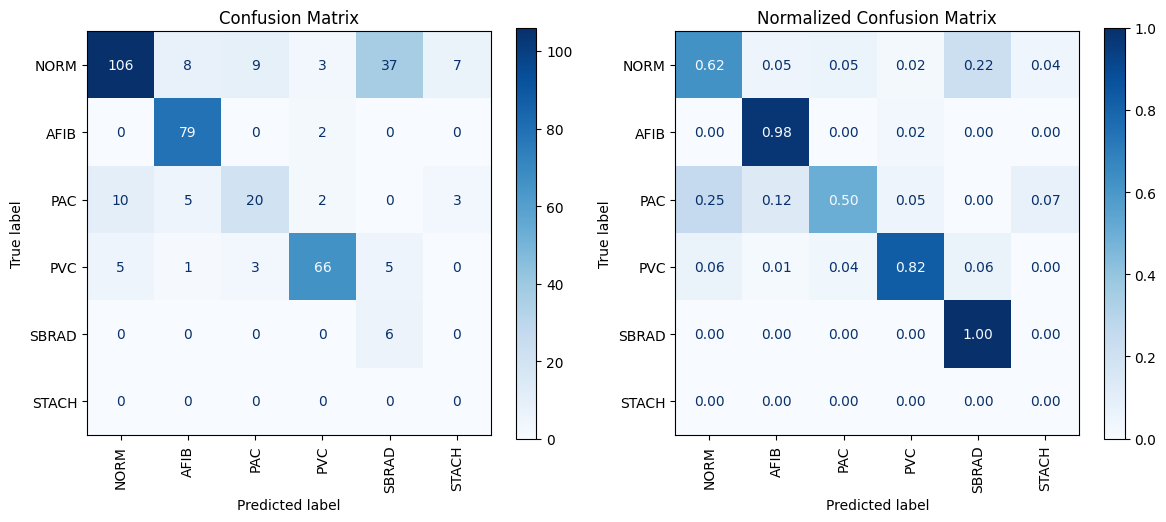

In [24]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['NORM', 'AFIB', 'PAC', 'PVC', 'SBRAD', 'STACH']

# Normalize
cm_normalized = np.divide(
    cm.astype('float'),
    cm.sum(axis=1)[:, np.newaxis],
    out=np.zeros_like(cm, dtype=float),
    where=cm.sum(axis=1)[:, np.newaxis] != 0
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Raw confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp1.plot(ax=ax1, cmap='Blues', xticks_rotation='vertical', colorbar=True)
ax1.set_title("Confusion Matrix")

# Normalized confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp2.plot(ax=ax2, cmap='Blues', xticks_rotation='vertical', values_format=".2f", colorbar=True)
ax2.set_title("Normalized Confusion Matrix")

plt.tight_layout()
plt.show()

Retrained HDC (new data only)

In [25]:
model = ECGNet().to(device)
model.load_state_dict(torch.load("./models/ECGNet_weightedLoss.pth"))
model.eval()

HD_DIM = 10000
FEATURE_DIM = 144  # output of CNN before classifier

# Create projection layer
projection = Projection(in_features=FEATURE_DIM, out_features=HD_DIM)

# Create an HDC classifier (e.g., centroid-based)
num_classes = 5
hd_classifier = Centroid(HD_DIM, num_classes)

for idx in range(train_dataset.__len__()):
    x, y = train_dataset.__getitem__(idx)
    label = y.item()

    x = x.unsqueeze(0).to(device)  # shape: (1, 1, 2500)
    y = y.unsqueeze(0).to(device)

    feat = extract_features(x, model)     # → shape: (1, 144)
    hv = projection(feat)          # → shape: (1, 10000)

    hd_classifier.add(hv, y)       # add to HDC class prototype

# Normalize after training
hd_classifier.normalize()

In [26]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for idx in range(test_dataset.__len__()):
        x, y = test_dataset.__getitem__(idx)
        x = x.unsqueeze(0).to(device)  # shape: (1, 1, 2500)
        y = y.item()

        feats = extract_features(x, model)   # shape: (1, 144)
        hv = projection(feats)              # shape: (1, 10000)
        out = hd_classifier(hv)             # shape: (1, num_classes)

        pred = out.argmax(dim=1).item()

        all_preds.append(pred)
        all_labels.append(y)

print(classification_report(all_labels, all_preds, target_names=['NORM', 'AFIB', 'PAC', 'PVC', 'SBRAD']))

              precision    recall  f1-score   support

        NORM       0.89      0.71      0.79       170
        AFIB       0.83      0.98      0.90        81
         PAC       0.68      0.57      0.62        40
         PVC       0.85      0.80      0.83        80
       SBRAD       0.16      1.00      0.28         6

    accuracy                           0.78       377
   macro avg       0.68      0.81      0.68       377
weighted avg       0.84      0.78      0.80       377



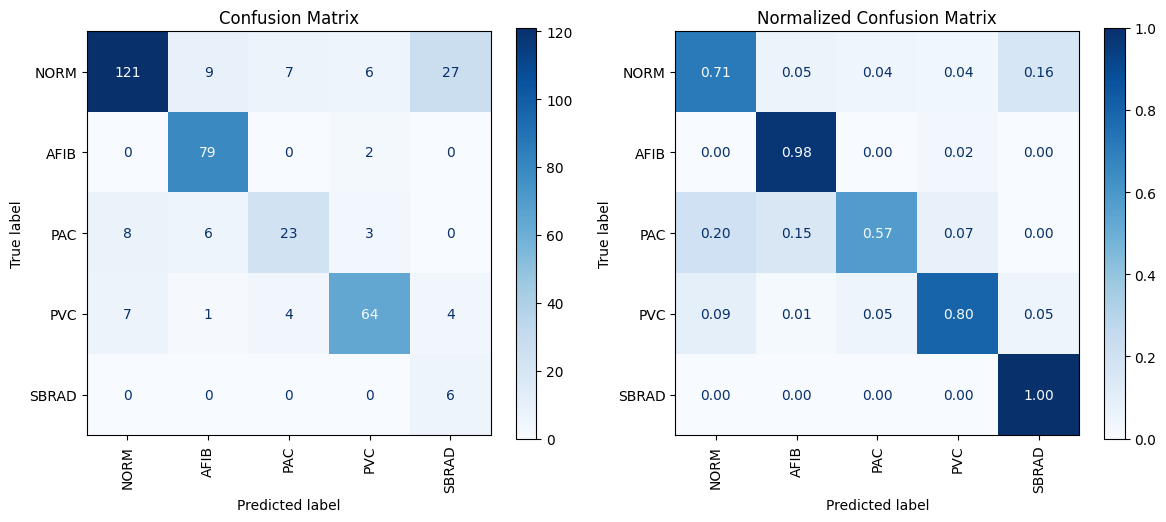

In [27]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['NORM', 'AFIB', 'PAC', 'PVC', 'SBRAD']

# Normalize
cm_normalized = np.divide(
    cm.astype('float'),
    cm.sum(axis=1)[:, np.newaxis],
    out=np.zeros_like(cm, dtype=float),
    where=cm.sum(axis=1)[:, np.newaxis] != 0
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Raw confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp1.plot(ax=ax1, cmap='Blues', xticks_rotation='vertical', colorbar=True)
ax1.set_title("Confusion Matrix")

# Normalized confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp2.plot(ax=ax2, cmap='Blues', xticks_rotation='vertical', values_format=".2f", colorbar=True)
ax2.set_title("Normalized Confusion Matrix")

plt.tight_layout()
plt.show()

ECGNet

In [ ]:
model = ECGNet().to(device)
model.load_state_dict(torch.load("./models/ECGNet_weightedLoss.pth"))
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(y_test.cpu().numpy())

print(classification_report(test_labels, test_preds, target_names=['NORM', 'AFIB', 'PAC', 'PVC', 'SBRAD', 'STACH'], zero_division=0))

              precision    recall  f1-score   support

        NORM       0.82      0.70      0.75       170
        AFIB       0.81      0.95      0.88        81
         PAC       0.71      0.30      0.42        40
         PVC       0.84      0.79      0.81        80
       SBRAD       0.14      0.83      0.24         6
       STACH       0.00      0.00      0.00         0

    accuracy                           0.73       377
   macro avg       0.55      0.60      0.52       377
weighted avg       0.80      0.73      0.75       377



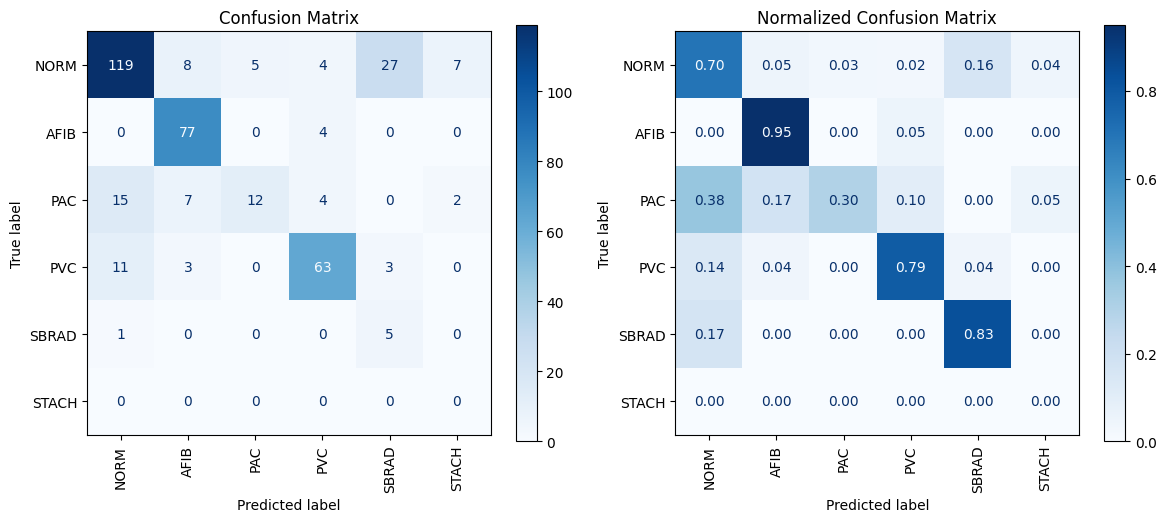

In [10]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
class_names = ['NORM', 'AFIB', 'PAC', 'PVC', 'SBRAD', 'STACH']

# Normalize
cm_normalized = np.divide(
    cm.astype('float'),
    cm.sum(axis=1)[:, np.newaxis],
    out=np.zeros_like(cm, dtype=float),
    where=cm.sum(axis=1)[:, np.newaxis] != 0
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Raw confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp1.plot(ax=ax1, cmap='Blues', xticks_rotation='vertical', colorbar=True)
ax1.set_title("Confusion Matrix")

# Normalized confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp2.plot(ax=ax2, cmap='Blues', xticks_rotation='vertical', values_format=".2f", colorbar=True)
ax2.set_title("Normalized Confusion Matrix")

plt.tight_layout()
plt.show()

Retrained ECGNet

In [ ]:
model = ECGNet().to(device)
model.load_state_dict(torch.load("./models/ECGNet_weightedLoss.pth"))

for param in model.features.parameters():
    param.requires_grad = False

y_train = [train_dataset[i][1].item() if torch.is_tensor(train_dataset[i][1]) else train_dataset[i][1] 
           for i in range(len(train_dataset))]
class_counts = np.bincount(y_train)
num_classes = 6
weights = torch.zeros(num_classes, dtype=torch.float)
for i in range(len(class_counts)):
    weights[i] = 1. / class_counts[i] if class_counts[i] > 0 else 0.
criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)

In [ ]:
best_acc = 0.0
best_model_path = "./models/ECGNet_retrained.pth"

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    train_acc = accuracy_score(all_labels, all_preds)
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f} | Train Accuracy: {train_acc:.4f}")

    # === Use test set to monitor best model ===
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            outputs = model(X_test)
            preds = torch.argmax(outputs, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(y_test.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    print(f"Test Accuracy: {test_acc:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model updated")

print(f"Best Test Accuracy: {best_acc:.4f}")

[Epoch 1] Loss: 12.1255 | Train Accuracy: 0.6960
Test Accuracy: 0.7374
Best model updated
[Epoch 2] Loss: 9.7485 | Train Accuracy: 0.7120
Test Accuracy: 0.7480
Best model updated
[Epoch 3] Loss: 8.3028 | Train Accuracy: 0.7080
Test Accuracy: 0.7480
[Epoch 4] Loss: 6.6664 | Train Accuracy: 0.7160
Test Accuracy: 0.7586
Best model updated
[Epoch 5] Loss: 5.4924 | Train Accuracy: 0.7240
Test Accuracy: 0.7507
[Epoch 6] Loss: 4.8581 | Train Accuracy: 0.7400
Test Accuracy: 0.7586
[Epoch 7] Loss: 4.5874 | Train Accuracy: 0.7280
Test Accuracy: 0.7586
[Epoch 8] Loss: 4.2692 | Train Accuracy: 0.7040
Test Accuracy: 0.7374
[Epoch 9] Loss: 3.6847 | Train Accuracy: 0.6720
Test Accuracy: 0.7294
[Epoch 10] Loss: 3.5372 | Train Accuracy: 0.7080
Test Accuracy: 0.7321
[Epoch 11] Loss: 3.2772 | Train Accuracy: 0.6920
Test Accuracy: 0.7560
[Epoch 12] Loss: 3.2472 | Train Accuracy: 0.7280
Test Accuracy: 0.7692
Best model updated
[Epoch 13] Loss: 3.0173 | Train Accuracy: 0.7520
Test Accuracy: 0.7825
Best mode

In [ ]:
model = ECGNet().to(device)
model.load_state_dict(torch.load("./models/ECGNet_retrained.pth"))
model.eval()
test_preds, test_labels, test_scores = [], [], []
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(y_test.cpu().numpy())

all_classes = ['NORM', 'AFIB', 'PAC', 'PVC', 'SBRAD', 'STACH']
all_class_indices = list(range(len(all_classes)))  # ensures every class is included

print(classification_report(
    test_labels,
    test_preds,
    labels=all_class_indices,
    target_names=all_classes,
    zero_division=0
))

              precision    recall  f1-score   support

        NORM       0.89      0.86      0.87       170
        AFIB       0.87      0.99      0.92        81
         PAC       0.67      0.65      0.66        40
         PVC       0.92      0.86      0.89        80
       SBRAD       0.57      0.67      0.62         6
       STACH       0.00      0.00      0.00         0

    accuracy                           0.86       377
   macro avg       0.65      0.67      0.66       377
weighted avg       0.86      0.86      0.86       377



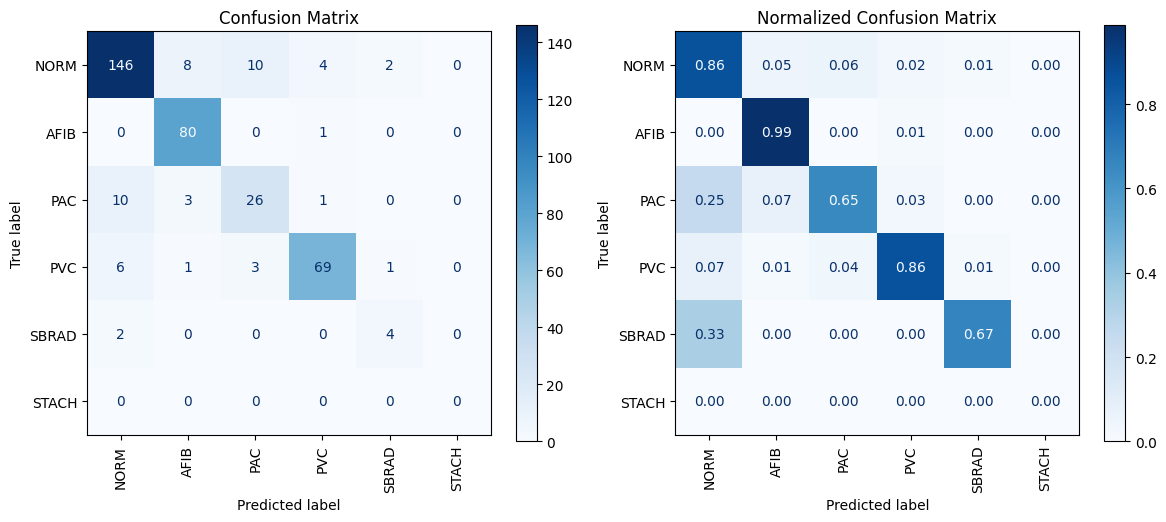

In [39]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds, labels=all_class_indices)

# Normalize
cm_normalized = np.divide(
    cm.astype('float'),
    cm.sum(axis=1)[:, np.newaxis],
    out=np.zeros_like(cm, dtype=float),
    where=cm.sum(axis=1)[:, np.newaxis] != 0
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Raw confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
disp1.plot(ax=ax1, cmap='Blues', xticks_rotation='vertical', colorbar=True)
ax1.set_title("Confusion Matrix")

# Normalized confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=all_classes)
disp2.plot(ax=ax2, cmap='Blues', xticks_rotation='vertical', values_format=".2f", colorbar=True)
ax2.set_title("Normalized Confusion Matrix")

plt.tight_layout()
plt.show()